# Livrable 1 - classification d'images

# Dépendances
Les dépandances nécessaires à la bonne exécution du code.

In [2]:
#Import des dépendances
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from collections import defaultdict
import shutil
import random
import kaggle
import requests
from zipfile import ZipFile

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img

# Analyse du dataset
Dans cette partie, nous allons analyser le dataset afin d'identifier les actions nécessaires à son utilisation pour entraîner notre IA.

## Informations sur le dataset
Nous parcourons le dataset pour récupérer les différentes classes ainsi que le nombre de données (images) par classe.

Nous affichons ensuite un histogramme pour une meilleure visualisation.

Classes :  ['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']
Nombre d'images par classe :  [18678, 18642, 12434, 2600, 10000]


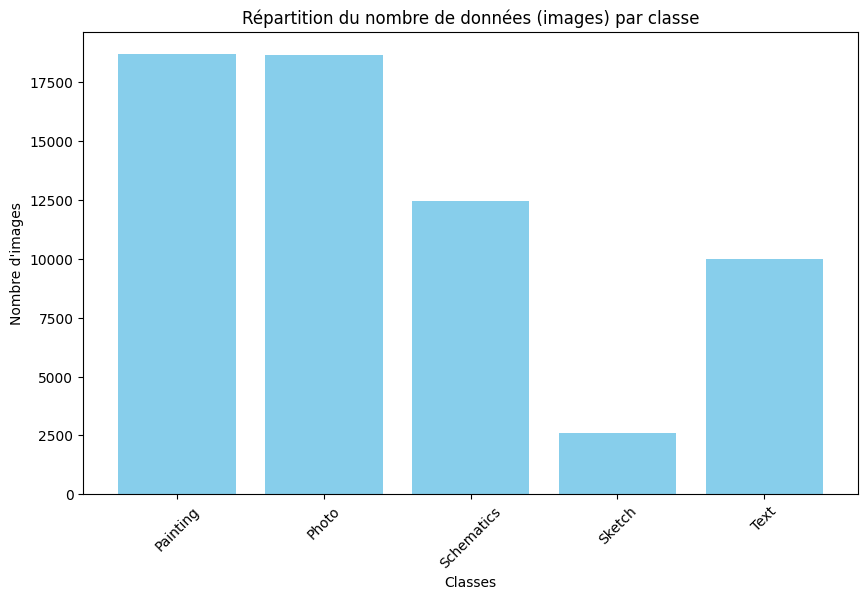

In [42]:
# Chemin vers le dataset
dataset_path = "./Dataset/Dataset1" # Chemin vers le dataset à modifier

# Vérification de l'existence du dossier
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Le dossier {dataset_path} n'existe pas.")

# Récupération des classes et du nombre d'images par classe
classes = []
image_counts = []

# Parcours des fichiers dans le dataset
for class_name in os.listdir(dataset_path):  # Parcours des fichiers dans le dataset
    class_path = os.path.join(dataset_path, class_name)  # Chemin vers le fichier
    classes.append(class_name.replace('Dataset Livrable 1 - ',''))  # Ajout du nom de la classe sans l'extension
    image_counts.append(len(os.listdir(class_path)))  # Comptage des fichiers dans le dossier

# Affichage des classes et du nombre d'images par classe
print("Classes : ", classes)
print("Nombre d'images par classe : ", image_counts)

# Affichage de l'histogramme
plt.figure(figsize=(10, 6))
plt.bar(classes, image_counts, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Nombre d\'images')
plt.title('Répartition du nombre de données (images) par classe')
plt.xticks(rotation=45)
plt.show()

## Afficher des images
Fonction pour afficher une image aléatoire par classe.

In [4]:
def display_random_images(dataset_path):
    """
    Affiche un nombre aléatoire d'images d'une classe donnée.
    
    :param dataset_path: Chemin vers le dataset
    :param num_images: Nombre d'images à afficher (par défaut 5)
    """
    fig, axes = plt.subplots(1, len(classes), figsize=(15, 5))
    for idx, class_name in enumerate(classes):
        class_path = os.path.join(dataset_path, class_name)
        images = os.listdir(class_path)
        random_image = random.choice(images)
        img_path = os.path.join(class_path, random_image)
        img = PIL.Image.open(img_path)
        axes[idx].imshow(img)
        axes[idx].set_title(class_name)
        axes[idx].axis("off")
    plt.tight_layout()
    plt.show()

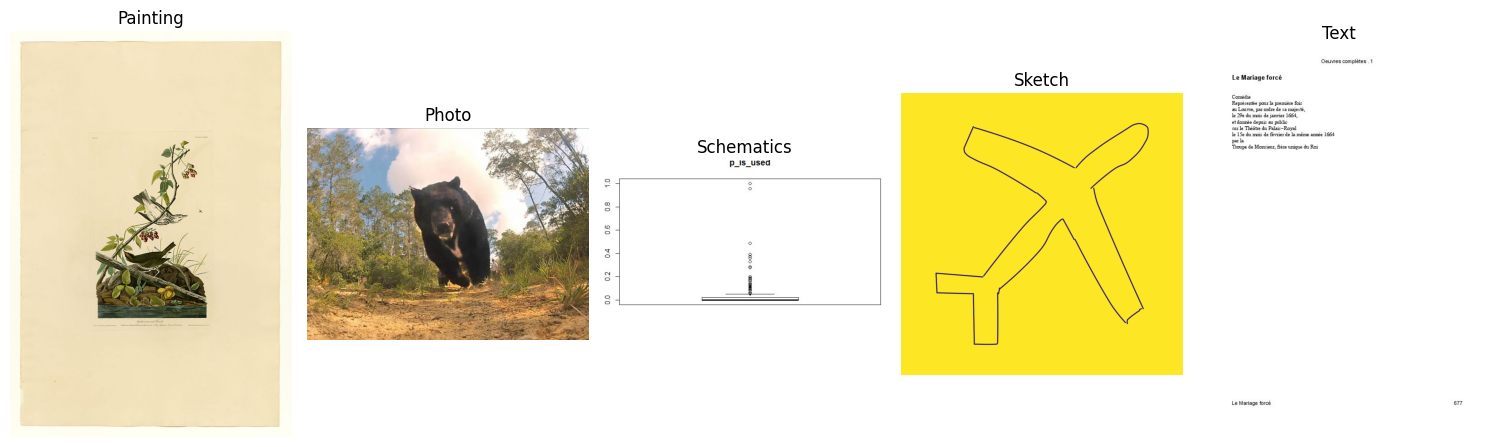

In [5]:

display_random_images(dataset_path)  # Affichage de 5 images aléatoires d'une classe donnée

## Nettoyage des données
La fonction suivante permet de parcourir le dataset et de supprimer les fichiers non images et les images corrompus.

In [6]:
# Suppresion des fichiers corrompus ou non images --------------------------------------------------------------------
def clean_images_dataset(dataset_path_arg):
    """
    Fonction pour nettoyer le dataset en supprimant les fichiers corrompus ou non images.
    """
    # Dictionnaire pour stocker le nombre d'images corrompues par classe
    corrupted_count_by_class = defaultdict(int)
    dataset_path = dataset_path_arg
    print("Début de la vérification des images ...")

    # Récupération de toutes les images pour calculer la progression
    all_files = []
    for dir_name in os.listdir(dataset_path): 
        dir_path = os.path.join(dataset_path, dir_name)
        for file_name in os.listdir(dir_path):
            all_files.append((dir_name, dir_path, file_name))

    total_files = len(all_files)
    checked_files = 0  # Pour la progression

    # Parcours des images avec affichage de la progression
    for dir_name, dir_path, file_name in all_files:
        if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            try:
                with open(os.path.join(dir_path, file_name), 'rb') as file:
                    img_bytes = file.read()  # Lire les bytes de l'image
                    img = tf.image.decode_image(img_bytes)  # Essayer de décoder l'image
            except Exception as e:
                corrupted_count_by_class[dir_name] += 1
                print(f"\nImage corrompue : {file_name} dans {dir_name}. Exception: {e}")
                os.remove(os.path.join(dir_path, file_name))
                print(f"Image {file_name} supprimée.")
        else:
            corrupted_count_by_class[dir_name] += 1
            print(f"\nLe fichier {file_name} dans {dir_name} n'est pas une image.")
            os.remove(os.path.join(dir_path, file_name))
            print(f"Fichier {file_name} supprimé.")

        # Mise à jour de la progression
        checked_files += 1
        progress = (checked_files / total_files) * 100
        print(f"\rProgression : [{int(progress)}%] {checked_files}/{total_files} images vérifiées", end="")

    print("\nVérification des fichiers terminée.")

    # Affichage du nombre d'images corrompues par dossier
    for dir_name, count in corrupted_count_by_class.items():
        print(f"Dossier {dir_name} : {count} images corrompues")

    # Nombre total d'images corrompues
    total_corrupted = sum(corrupted_count_by_class.values())
    print(f"Nombre total d'images corrompues ou non image : {total_corrupted}")


In [7]:
#clean_images_dataset(dataset_path)

Fonction pour séparer les images jpg et png d'un dossier.

In [8]:
def separate_images(source_folder):
    # Définition des dossiers de destination
    jpg_folder = source_folder + "_jpg"
    png_folder = source_folder + "_png"
    
    # Création des dossiers s'ils n'existent pas
    os.makedirs(jpg_folder, exist_ok=True)
    os.makedirs(png_folder, exist_ok=True)
    
    # Parcours des fichiers dans le dossier source
    for filename in os.listdir(source_folder):
        file_path = os.path.join(source_folder, filename)
        
        # Vérification que c'est bien un fichier
        if os.path.isfile(file_path):
            if filename.lower().endswith(".jpg") or filename.lower().endswith(".jpeg"):
                shutil.move(file_path, os.path.join(jpg_folder, filename))
            elif filename.lower().endswith(".png"):
                shutil.move(file_path, os.path.join(png_folder, filename))
    
    print("Séparation terminée !")

In [9]:
# separate_images("./Dataset/Dataset1/Sketch/")

## Import des données
Nous déclarons également nos variables pour le futur entraînement de notre modèle.

Nous importons nos données grâce à TensorFlow afin de les manipuler par la suite avec cette librairie.

In [32]:
image_size = (180, 180)  # Taille des images
batch_size = 32  # Taille du lot
epochs = 100  # Nombre d'époques

# chargement des images
# Le train_set
train_set = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="training",
  seed=42,
  batch_size=batch_size,
  image_size=image_size
)

# Le test_set
test_set = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=42,
  batch_size=batch_size,
  image_size=image_size
)

Found 42592 files belonging to 5 classes.
Using 34074 files for training.
Found 42592 files belonging to 5 classes.
Using 8518 files for validation.


## Amélioration du dataset
Grâce à notre exploration des données précédentes, nous avons remarqué que l'une de nos classes (Sketch) possède un nombre de données bien inférieur aux autres classes.

Pour y remédier, plusieurs solutions sont envisageables :
- Augmenter la taille du dataset en ajoutant de nouvelles données provenant d'autres datasets.
- Générer de nouvelles données en appliquant des transformations sur les données existantes (rotations, zooms, flou, etc.).
- Ajuster la pondération des classes afin de compenser ce déséquilibre et améliorer l'apprentissage du modèle.

### Ajout de nouvelles données au dataset
Augmente la taille du dataset en ajoutant de nouvelles données provenant d'autres datasets.
- Dataset pour les sketch jpg : https://cybertron.cg.tu-berlin.de/eitz/projects/classifysketch/
- Dataset pour les sketch png : https://cybertron.cg.tu-berlin.de/eitz/projects/classifysketch/sketches_png.zip (https://www.kaggle.com/datasets/arbazkhan971/cuhk-face-sketch-database-cufs)

In [29]:
def download_kaggle_dataset(dataset_name, destination_folder):
    """
    Télécharge un dataset Kaggle en utilisant l'API Kaggle.
    Assurez-vous d'avoir configuré votre fichier kaggle.json dans ~/.kaggle/.
    """
    os.makedirs(destination_folder, exist_ok=True)
    try:
        os.system(f"kaggle datasets download -d {dataset_name} -p {destination_folder}")
    except ImportError:
        raise ImportError("Le module 'kaggle' n'est pas installé. Veuillez l'installer avec 'pip install kaggle'.")
    zip_path = os.path.join(destination_folder, f"{dataset_name.split('/')[-1]}.zip")
    print(zip_path)
    with ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(destination_folder)
    os.remove(zip_path)
    print(f"Dataset {dataset_name} téléchargé et extrait dans {destination_folder}.")

def download_http_dataset(url, destination_folder):
    """
    Télécharge un dataset depuis une URL HTTP.
    """
    os.makedirs(destination_folder, exist_ok=True)
    file_name = os.path.join(destination_folder, url.split('/')[-1])
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(file_name, 'wb') as f:
            for chunk in response.iter_content(chunk_size=1024):
                f.write(chunk)
        print(f"Fichier téléchargé : {file_name}")
        if file_name.endswith('.zip'):
            with ZipFile(file_name, 'r') as zip_ref:
                zip_ref.extractall(destination_folder)
            os.remove(file_name)
            print(f"Fichier extrait dans {destination_folder}.")
    else:
        print(f"Échec du téléchargement depuis {url}.")

def delete_duplicate_images(dataset_path):
    """
    Supprime les images dupliquées dans le dataset.
    """
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            seen_images = set()
            for filename in os.listdir(class_path):
                file_path = os.path.join(class_path, filename)
                if filename in seen_images:
                    print(f"Image dupliquée supprimée : {file_path}")
                    os.remove(file_path)
                else:
                    seen_images.add(filename)


def add_datas_to_dataset(dataset_path, dataset_faces_path, dataset_sketch_path):
    """
    Remplace les images du dossier Sketch dans dataset_path
    par celles venant de png/airplane et original_sketch.
    """

    # Chemin vers la classe cible dans le dataset principal
    target_class_path = os.path.join(dataset_path, "Sketch")
    
    # On supprime les anciennes images (s'il y en a)
    # if os.path.exists(target_class_path):
    #     for filename in os.listdir(target_class_path):
    #         file_path = os.path.join(target_class_path, filename)
    #         if os.path.isfile(file_path):
    #             os.remove(file_path)
    # else:
    #     os.makedirs(target_class_path)

    # Définir les chemins source
    sketch_airplane_path = os.path.join(dataset_sketch_path, "png", "airplane")
    original_sketch_path = os.path.join(dataset_faces_path, "original_sketch")

    # Fusionner les deux dossiers source
    for src_path in [sketch_airplane_path, original_sketch_path]:
        if os.path.exists(src_path):
            for image_name in os.listdir(src_path):
                source_image_path = os.path.join(src_path, image_name)
                if os.path.isfile(source_image_path):
                    shutil.copy(source_image_path, target_class_path)

    # Supprimer les dossiers temporaires
    shutil.rmtree(dataset_faces_path, ignore_errors=True)
    shutil.rmtree(dataset_sketch_path, ignore_errors=True)
    print(f"Dossiers temporaires supprimés :\n- {sketch_airplane_path}\n- {original_sketch_path}")

    print(f"Images copiées depuis :\n- {sketch_airplane_path}\n- {original_sketch_path}\nvers : {target_class_path}")


    
    

In [ ]:
# Télécharge les datasets depuis Kaggle et HTTP, les ajoute au dataset principal et supprime les images dupliquées
# Assurez-vous d'avoir configuré votre fichier kaggle.json dans ~/user/name/.kaggle/ pour utiliser l'API Kaggle

# Télécharger le dataset Kaggle
download_kaggle_dataset("arbazkhan971/cuhk-face-sketch-database-cufs", "./Dataset/CUHK_Face_Sketch_Database")

# Télécharger le dataset depuis une URL HTTP
download_http_dataset("https://cybertron.cg.tu-berlin.de/eitz/projects/classifysketch/sketches_png.zip", "./Dataset/classifysketch")

# Merger les datasets
add_datas_to_dataset(dataset_path, "./Dataset/CUHK_Face_Sketch_Database", "./Dataset/classifysketch")

# Supprimer les images dupliquées
delete_duplicate_images(dataset_path)

### Datas augmentation
Génére de nouvelles données en appliquant des transformations sur les données existantes (rotations, zooms, flou, etc.).

In [ ]:

def datas_augmentation(dataset_path, class_to_augment ,num_images_gen=2):
    """
    Fonction pour générer des images augmentées à partir d'un dataset existant pour toutes les classes.
    """
    # Data Augmentation
    datagen = ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

 
    dir_path = os.path.join(dataset_path, class_to_augment)
    # print(f"Traitement du dossier : {dir_path}")
    for image_name in os.listdir(dir_path):
        img_path = os.path.join(dir_path, image_name)
        # print(f"Traitement de l'image : {img_path}")
        img = load_img(img_path)  # Charger l'image
        img = img_to_array(img)   # Convertir en tableau numpy
        img = np.expand_dims(img, axis=0)

        i = 0
        for batch in datagen.flow(img, batch_size=1, save_to_dir=dir_path, save_prefix='aug', save_format='jpeg'):
            i += 1
            if i >= num_images_gen:  # Générer environ X nouvelles images par image existante (pour arriver à 10k)
                break


In [ ]:
datas_augmentation(dataset_path, "Sketch",2)

KeyboardInterrupt: 

### Ponderation

In [45]:
from sklearn.utils.class_weight import compute_class_weight

def compute_class_weights(dataset_path):
    """
    Calcule les poids des classes en fonction du nombre d'images par dossier de classe.

    Args:
        dataset_path (str): Chemin vers le dossier contenant les sous-dossiers de classes.

    Returns:
        dict: Dictionnaire {nom_de_classe: poids}.
    """
    y_labels = []

    # Parcours de chaque dossier de classe
    for class_name in os.listdir(dataset_path):
        class_dir = os.path.join(dataset_path, class_name)

        # Vérifie que c’est bien un dossier
        if os.path.isdir(class_dir):
            image_files = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
            
            # Ajoute autant de fois la classe que d'images dans le dossier
            y_labels.extend([class_name] * len(image_files))

    # Transforme la liste en tableau numpy
    y_labels = np.array(y_labels)
    
    # Calcule les poids
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_labels), y=y_labels)
    
    # Crée un dictionnaire {nom_classe: poids}
    class_weights_dict = {
        cls: weight for cls, weight in zip(np.unique(y_labels), class_weights)
    }

    return class_weights_dict

    

In [46]:

print("Poids des classes :", compute_class_weights(dataset_path))

Poids des classes : {np.str_('Painting'): np.float64(0.6676731984152479), np.str_('Photo'): np.float64(0.6689625576654865), np.str_('Schematics'): np.float64(1.0029596268296606), np.str_('Sketch'): np.float64(4.796461538461538), np.str_('Text'): np.float64(1.24708)}


# Pipeline Classification